In [52]:
import glob
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd
import imghdr
import shutil
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

images_folder = '../images'

In [2]:
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(images_folder + '/').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Shape of the image: (900, 1200, 3)


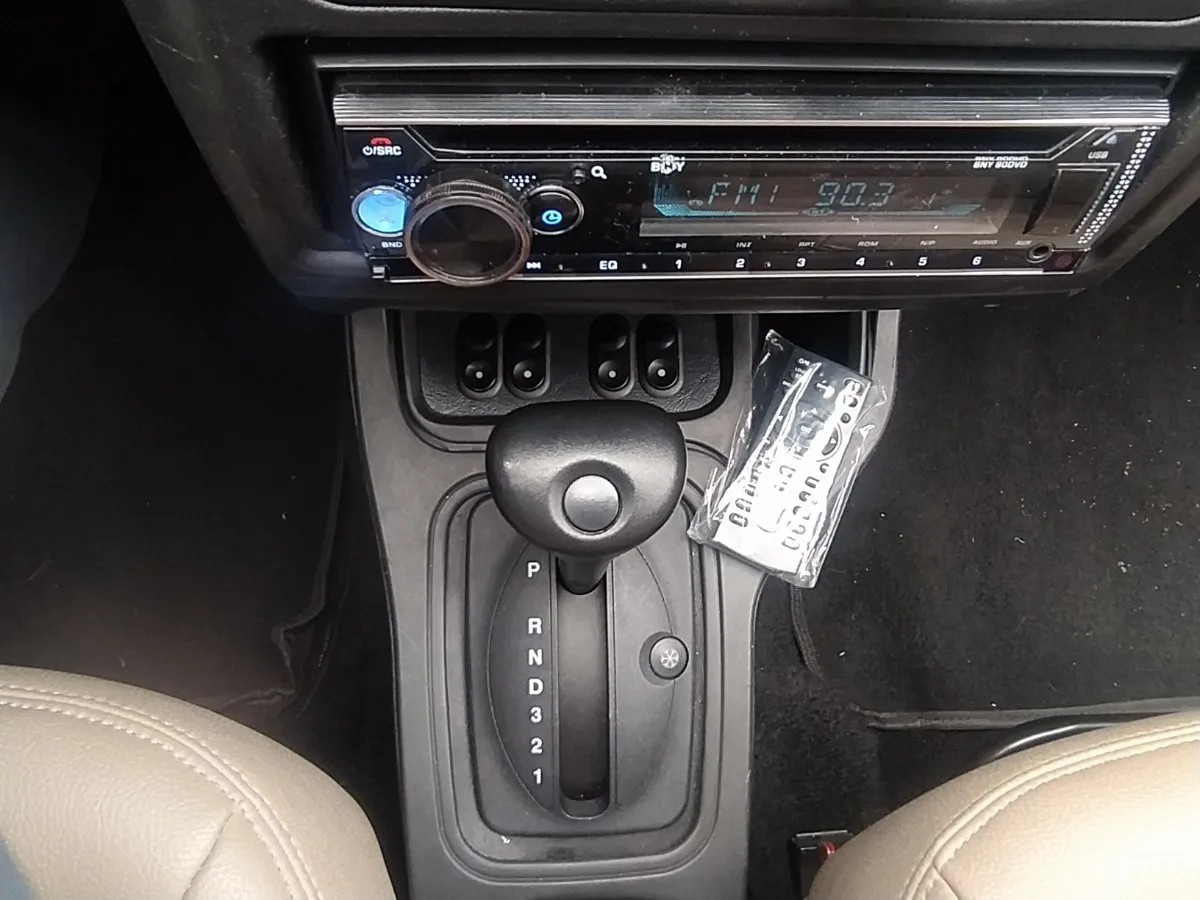

In [3]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = np.random.choice(image_files)

pil_image = tf.keras.preprocessing.image.load_img(image)
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

In [ ]:
# create train and validation set
def create_train_validation_set(image_files, validation_split=0.2):
    train_set = []
    validation_set = []
    for image_file in image_files:
        if np.random.rand() < validation_split:
            # copy image to validation folder
            shutil.copy(image_file, image_file.replace('images', 'validation'))
        else:
            # copy image to train folder
            shutil.copy(image_file, image_file.replace('images', 'train'))

create_train_validation_set(image_files)

In [4]:
train_images_folder = '../train'
validation_images_folder = '../validation'

The image has a big resolution (1920 x 1458 x 3) which needs to be reduced for computational purposes.

In [5]:
# callback
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True


In [6]:
# import images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  train_images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=128,
)
validation_images = tf.keras.preprocessing.image_dataset_from_directory(
  validation_images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=32,
  shuffle=False,
)
labels = train_images.class_names

Found 6830 files belonging to 3 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 1667 files belonging to 3 classes.


2022-11-09 06:56:49.922799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-09 06:56:49.922922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1014, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.001),
  metrics=['accuracy'],
)

In [9]:
history = model.fit(
  train_images.repeat(),
  steps_per_epoch=32,
  epochs=200,
  verbose=1,
  callbacks=[AccReached()],
  validation_data=validation_images,
)

Epoch 1/200


2022-11-09 06:56:53.683932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-09 06:56:53.685790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.9150 - accuracy: 0.6663

2022-11-09 06:57:34.051436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 52s 1s/step - loss: 0.9150 - accuracy: 0.6663 - val_loss: 0.8202 - val_accuracy: 0.6947
Epoch 2/200
32/32 [==============================] - 50s 2s/step - loss: 0.8353 - accuracy: 0.7015 - val_loss: 0.7829 - val_accuracy: 0.6947
Epoch 3/200
32/32 [==============================] - 44s 1s/step - loss: 0.7888 - accuracy: 0.7026 - val_loss: 0.7273 - val_accuracy: 0.6995
Epoch 4/200
32/32 [==============================] - 50s 2s/step - loss: 0.7592 - accuracy: 0.7028 - val_loss: 0.6869 - val_accuracy: 0.7061
Epoch 5/200
32/32 [==============================] - 45s 1s/step - loss: 0.7169 - accuracy: 0.7236 - val_loss: 0.6466 - val_accuracy: 0.7193
Epoch 6/200
32/32 [==============================] - 54s 2s/step - loss: 0.6771 - accuracy: 0.7312 - val_loss: 0.6124 - val_accuracy: 0.7552
Epoch 7/200
32/32 [==============================] - 48s 2s/step - loss: 0.6545 - accuracy: 0.7434 - val_loss: 0.5944 - val_accuracy: 0.7774
Epoch 8/200
32/32 [======

In [10]:
validations_labels = np.array(list(validation_images.map(lambda image, label: label).unbatch().as_numpy_iterator()))
predictions = model.predict(validation_images, steps=53)

2022-11-09 08:59:25.973022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 13s 240ms/step


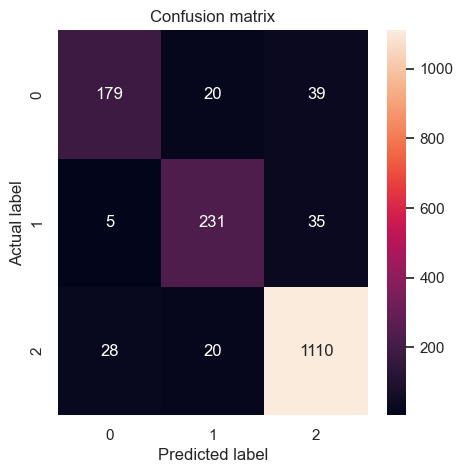

In [53]:
cm = confusion_matrix(validations_labels, np.argmax(predictions, axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

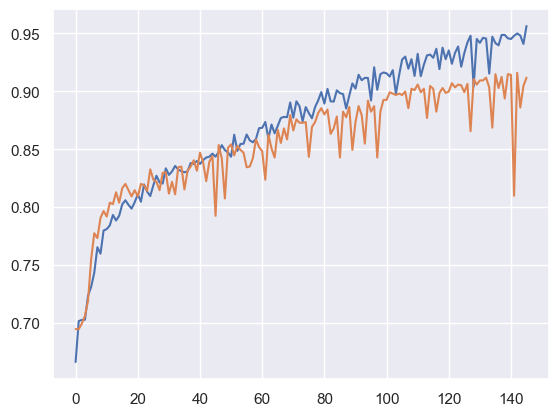

In [54]:
sns.lineplot(np.array(history.history['accuracy']))
sns.lineplot(np.array(history.history['val_accuracy']))
plt.show()

In [193]:
cls_a = np.where(np.argmax(predictions, axis=1) == 0, True, False)  # only get predictions for class a

In [194]:
# get the images that correspong to class a
images_a = np.array(list(validation_images.unbatch().map(lambda image, label: image).as_numpy_iterator()))[cls_a]

In [195]:
prediction_a = predictions[cls_a]  # get the probs predictions from model
true_a = validations_labels[cls_a]  # get the true values for predictions
errors_a = np.where(true_a != 0, True, False) # get the errors

In [196]:
print(errors_a.shape)
print(images_a.shape)

(212,)
(212, 256, 256, 3)


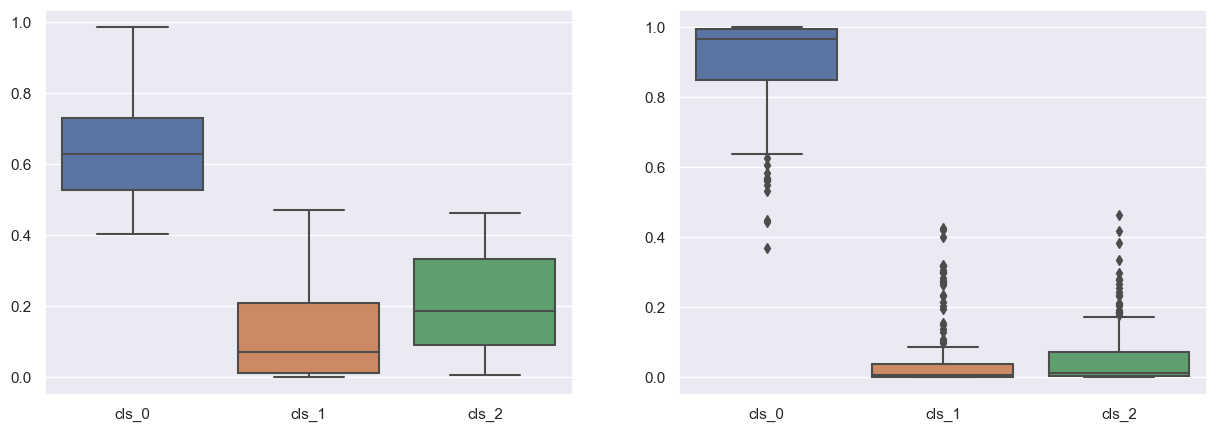

In [197]:
error_df = pd.DataFrame(prediction_a[errors_a], columns=['cls_0', 'cls_1', 'cls_2'])
correct_df = pd.DataFrame(prediction_a[~errors_a], columns=['cls_0', 'cls_1', 'cls_2'])
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

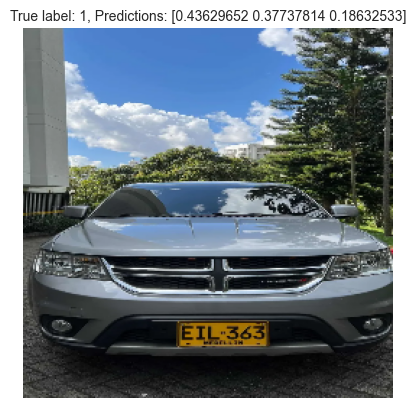

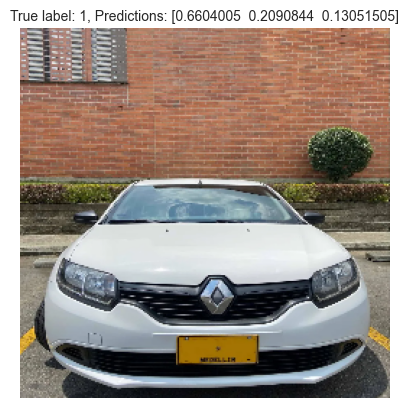

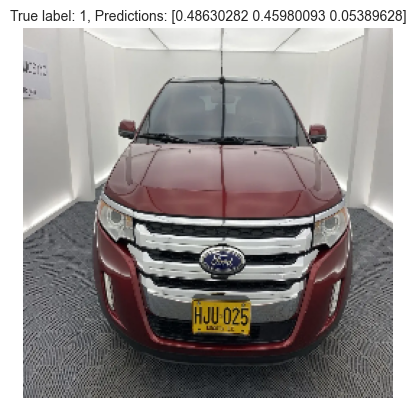

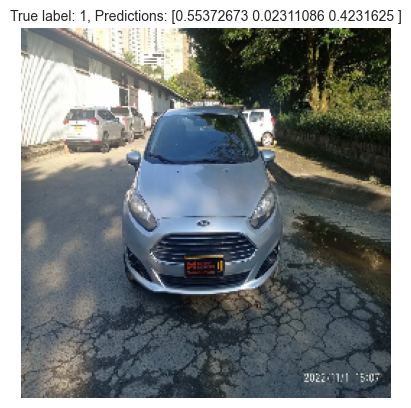

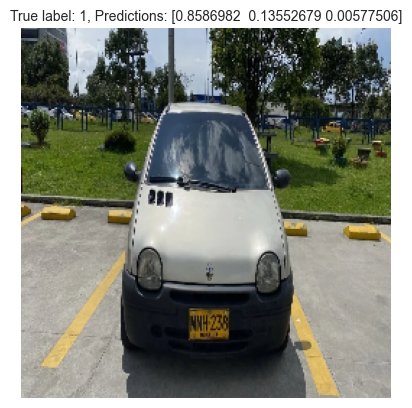

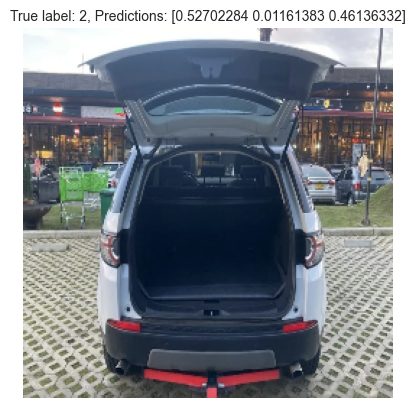

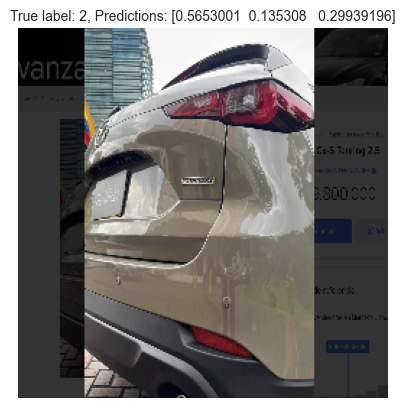

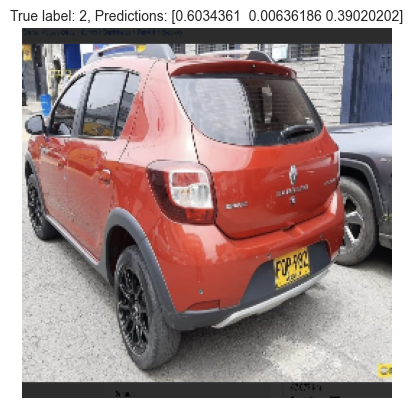

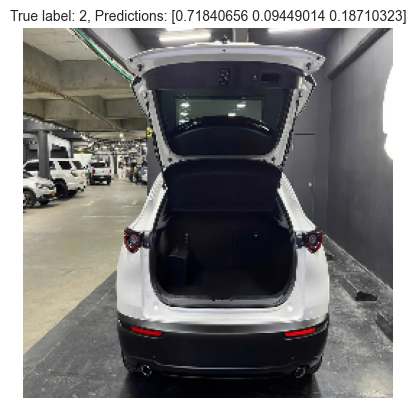

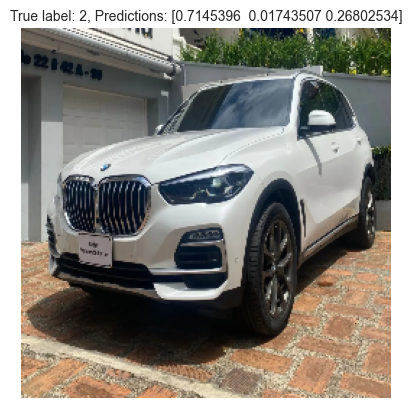

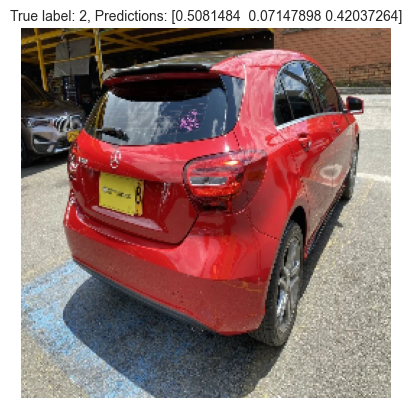

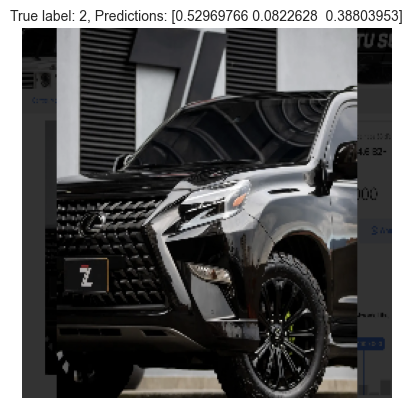

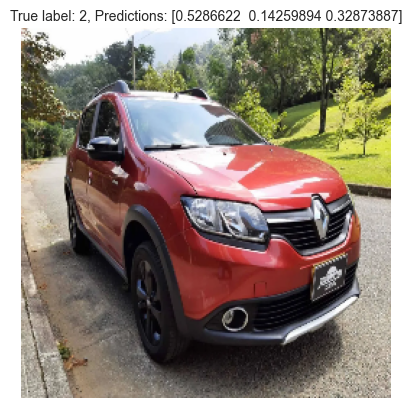

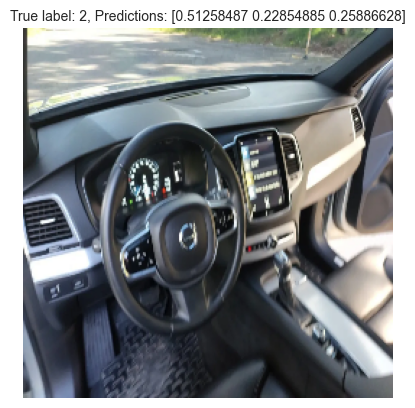

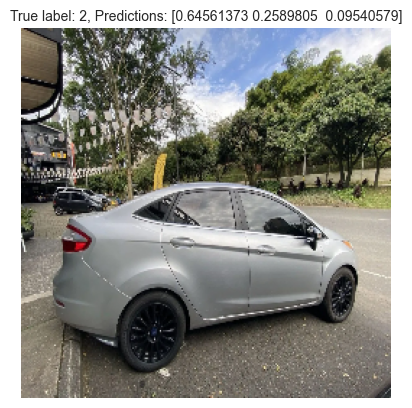

In [223]:
for i in range(15):
  error_image = tf.keras.utils.array_to_img(images_a[errors_a][i])
  fig = plt.figure()
  plt.imshow(error_image)
  plt.axis('off')
  plt.title(f'True label: {true_a[errors_a][i]}, Predictions: {prediction_a[errors_a][i]}', fontsize=10)
plt.show()

In [90]:
def plot_precision_recall(predictions, labels, class_index):
  cls_labels = np.where(validations_labels == class_index, 1, 0)
  precision, recall, thresholds = precision_recall_curve(cls_labels, predictions[:, class_index])
  prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
  
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  sns.lineplot(data=prt, ax=ax[0])
  ax[0].set_ylabel('Precision - Recall')
  ax[0].set_xlabel('Threshold')
  ax[0].set_title(f'Precision - Recall for {class_index}')

  sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
  ax[1].set_ylabel('Recall')
  ax[1].set_xlabel('Precision')
  ax[1].set_title(f'Precision vs Recall for {class_index}')
  plt.show()

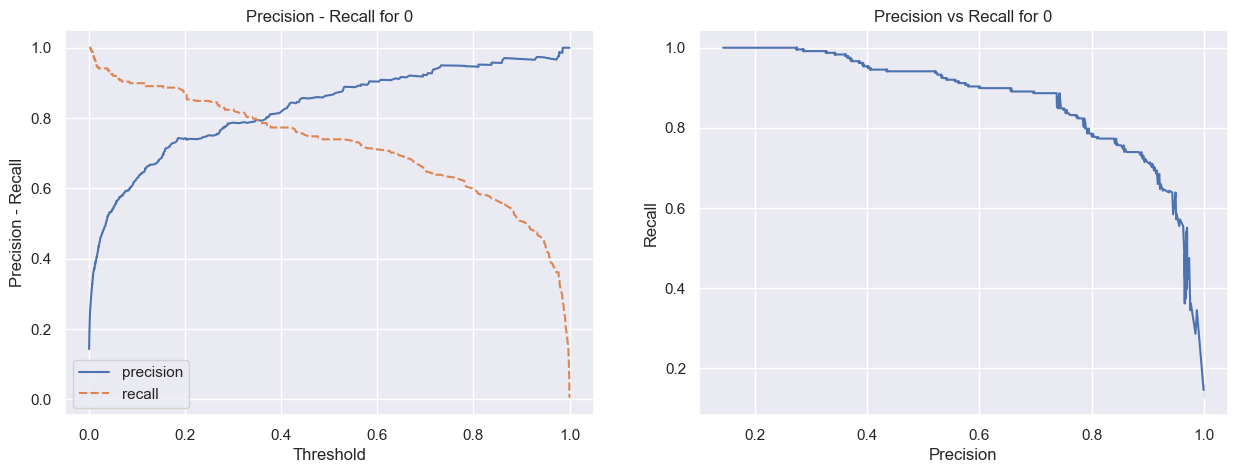

In [91]:
plot_precision_recall(predictions, validations_labels, 0)

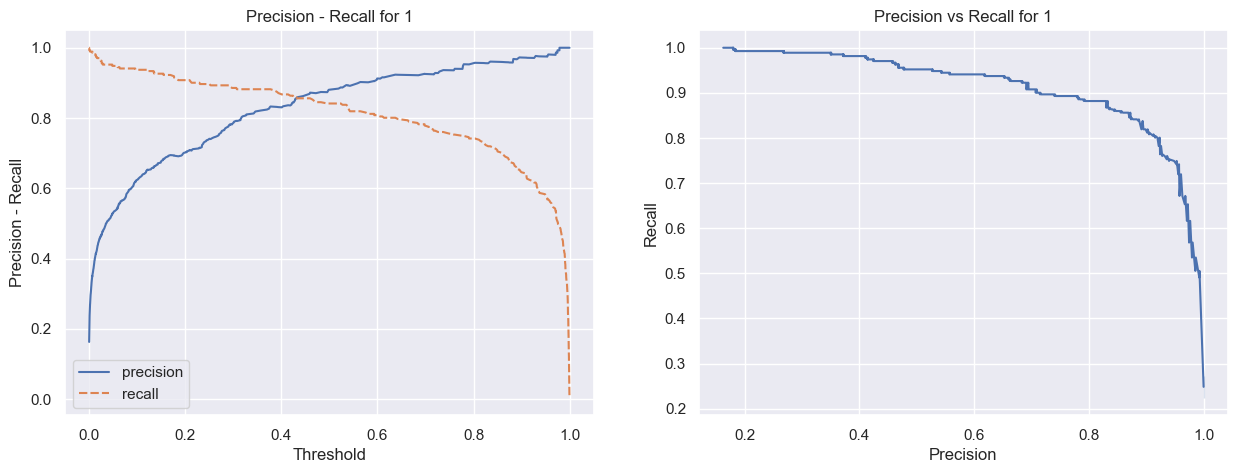

In [92]:
plot_precision_recall(predictions, validations_labels, 1)

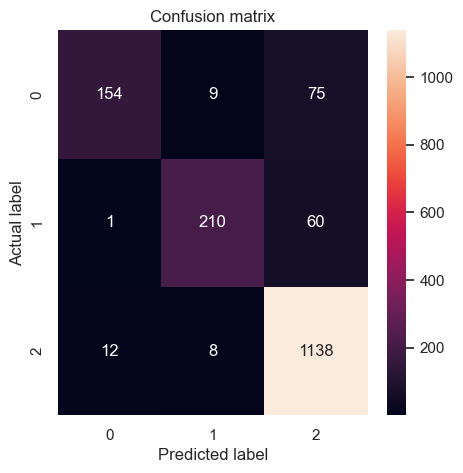

In [238]:
new_label_predictions = np.zeros(predictions.shape[0])
thresholld = 0.7
for idx, row in enumerate(predictions):
  if row[0] > thresholld:
    new_label_predictions[idx] = 0
  elif row[1] > thresholld:
    new_label_predictions[idx] = 1
  else:
    new_label_predictions[idx] = 2

cm = confusion_matrix(validations_labels, new_label_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
# save the model
model.save('labeling_model.h5')

In [218]:
labels

['back', 'front', 'other']